# ***실험내용***
---
- LLM(GPT 4o) 프롬프트를 통해 입력 쿼리 가공
- 쿼리로부터 실제 이미지로 구현되어야 하는 시각 요소들을 추출하고 각 요소별 중요도 판단
- 이와 별개로, 입력 쿼리를 생성 모델이 처리할 수 있는 효율적인 형태(text_sum)로 요약
- 시각 요소별로 일정 수만큼의 이미지를 검색하고 이를 생성에 보충
- 입력 이미지 + 요약 쿼리(text_sum) + 검색 이미지로 생성하고 결과에 따라 가중치 조정

## **Settings**

In [ ]:
# 필요한 라이브러리 설치
!pip install faiss-cpu langchain_community langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.5 MB/s eta 0:00:00


In [ ]:
# 필요한 라이브러리 불러오기
import faiss
import json
import torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
import os
import io
import requests
from PIL import Image
import PIL
from google.colab import files
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser
import sys
from langchain_community.document_loaders.csv_loader import CSVLoader as CommunityCSVLoader
from pathlib import Path
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
from langchain.document_loaders import CSVLoader as LangChainCSVLoader
from langchain.text_splitter import TextSplitter
from langchain.vectorstores import FAISS as LangChainFAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate
from diffusers import KandinskyPriorPipeline, KandinskyPipeline

## **임베딩 모델/칸딘스키 모델**

In [ ]:
# 임베딩 CLIP 모델 정보
model_name = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

# text 임베딩 벡터 반환
def encode_text(text):
    inputs = processor(text=[text], return_tensors="pt")

    with torch.no_grad():
        text_features = clip_model.get_text_features(**inputs)

    text_features = torch.nn.functional.normalize(text_features, p=2, dim=-1) #정규화

    return text_features.cpu().numpy().astype("float32")

# 유사 이미지 탐색
def search_similar_images(text, image_index, top_k=1):
    text_vec = encode_text(text)  # 텍스트 벡터화
    text_vec = text_vec.reshape(1, -1)  # (1, d) 형태로 변환

    # FAISS에서 요구하는 contiguous array와 dtype 맞추기
    x = np.ascontiguousarray(text_vec, dtype=np.float32)

    assert x.shape[1] == image_index.d, f"Dim mismatch: {x.shape[1]} vs FAISS index {image_index.d}"

    # top_k를 Python int형으로 변환
    k = int(top_k)

    # FAISS의 search 함수 호출
    distances, indices = image_index.search(x, k)

    image_embed_vectors = []
    for i in indices[0]:
        vec = np.zeros((image_index.d,), dtype=np.float32)
        image_index.reconstruct(int(i), vec)
        image_embed_vectors.append(vec)

    image_embed = torch.tensor(np.array(image_embed_vectors), dtype=torch.float32)

    return image_embed, distances

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
# 작업 디렉토리를 /content로 변경 (보장)
%cd /content

# 파일 업로드: 파일은 /content에 저장됨
uploaded_files = files.upload()

# 업로드된 파일 처리
for file_name in uploaded_files.keys():
    if file_name.endswith(".py"):
        temp_path = os.path.join("/content", file_name)
        target_path = "/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/kandinsky/pipeline_kandinsky_prior.py"

        # 시스템 경로는 직접 덮어쓰기가 어려울 수 있으므로 cp 명령어 사용
        os.system(f"cp {temp_path} {target_path}")
        print(f"✅ 파일 이동 완료: {target_path}")
    else:
        print("❌ ERROR: Python 파일이 아님")

/content


Saving pipeline_kandinsky_prior_s.py to pipeline_kandinsky_prior_s.py
✅ 파일 이동 완료: /usr/local/lib/python3.11/dist-packages/diffusers/pipelines/kandinsky/pipeline_kandinsky_prior.py


In [ ]:
# FAISS 벡터 DB 파일 경로 # 강아지, 고양이 이미지
faiss_index_filename = "/content/drive/MyDrive/DB/dog_ad.index"

# FAISS 인덱스 로드
db_index = faiss.read_index(faiss_index_filename)

# 모델 불러오기
pipe_prior = KandinskyPriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-1-prior", torch_dtype=torch.float16
)
pipe_prior.to("cuda")
pipe = KandinskyPipeline.from_pretrained("kandinsky-community/kandinsky-2-1", torch_dtype=torch.float16)
pipe.to("cuda")

model_index.json:   0%|          | 0.00/500 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

image_encoder%2Fconfig.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

(…)age_processor%2Fpreprocessor_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/626 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

prior%2Fconfig.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/495M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.09G [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/767 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

movq%2Fconfig.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/318 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/271M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer%2Ftokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You are using a model of type xlm-roberta to instantiate a model of type M-CLIP. This is not supported for all configurations of models and can yield errors.


KandinskyPipeline {
  "_class_name": "KandinskyPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "kandinsky-community/kandinsky-2-1",
  "movq": [
    "diffusers",
    "VQModel"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "kandinsky",
    "MultilingualCLIP"
  ],
  "tokenizer": [
    "transformers",
    "XLMRobertaTokenizerFast"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ]
}

## **입력 이미지 불러오기**

In [ ]:
# 이미지 입력 받기
upload_dir = "/uploads"
os.makedirs(upload_dir, exist_ok=True)

# 업로드된 이미지 경로 저장
uploaded_image_paths = []

# Colab에서 이미지 파일 업로드 및 저장
def upload_images():
    uploaded_files = files.upload()
    for file_name in uploaded_files.keys():
        file_path = os.path.join("/content", file_name)  # 기본 업로드 경로
        move_path = os.path.join(upload_dir, file_name)  # 사용자 지정 디렉토리

        # 파일을 원하는 디렉토리로 이동
        os.rename(file_path, move_path)

        uploaded_image_paths.append(move_path)
        print(f"save image : {move_path}")

# 버튼 설정
upload_button = widgets.Button(description="이미지 업로드")

# 클릭 시 실행
def on_upload_clicked(b):
    upload_images()

upload_button.on_click(on_upload_clicked)

# 출력
display(upload_button)

Button(description='이미지 업로드', style=ButtonStyle())

Saving 스크린샷 2025-02-19 오전 10.16.41.png to 스크린샷 2025-02-19 오전 10.16.41.png
Saving 스크린샷 2025-02-19 오전 10.16.46.png to 스크린샷 2025-02-19 오전 10.16.46.png
save image : /uploads/스크린샷 2025-02-19 오전 10.16.41.png
save image : /uploads/스크린샷 2025-02-19 오전 10.16.46.png


In [ ]:
# 입력 이미지 전처리
input_images = [Image.open(path).convert("RGB") for path in uploaded_image_paths] # 입력 이미지 리스트
input_images

[<PIL.Image.Image image mode=RGB size=374x400>,
 <PIL.Image.Image image mode=RGB size=382x374>]

## **서브쿼리 + 중요도 + 요약쿼리 생성**
- 복잡한 입력 쿼리 중에서 구현해야하는 시각요소를 추출
- 각 요소별로 중요도를 판단
- 이 정보를 JSON 파일로 저장하여 활용
- 별도로 쿼리의 효율적인 요약문을 만들어 최종 쿼리로 활용

In [ ]:
# api key
load_dotenv()

os.environ["OPENAI_API_KEY"] = "api-key"


def g_image(db_index, input_ratio, k) :

    # 쿼리문
    query_text = input('query :')

    # LLM 템플릿 구성
    template = """
    You are an expert in visual content decomposition and summarization for image generation. Your task is to analyze the given query text, extract key visual elements, and generate a concise yet comprehensive summary that preserves the essence of the original input while making it more efficient for image generation.

    ### **Instructions:**
    1. Carefully read the **query text** and extract the key visual elements that must appear in the generated image.
    2. Ensure that each extracted visual element is **specific and descriptive**. Use details from the query text where possible.
    3. Assign an **importance weight** (a value between 0 and 1) to each visual element, ensuring that the sum of all weights equals exactly **1**.
      - More crucial elements should have higher weights.
      - Less significant elements should have lower weights.
    4. Generate a **single-sentence summary (`query_text_sum`)** that captures all essential elements of the original query text while improving clarity and efficiency for image generation.
      - Keep all elements **connected in a single continuous sentence** to emphasize that they coexist in the same image.
      - Remove unnecessary words, redundancies, or overly complex structures.
      - Preserve the intent and artistic vision of the original query text.
    5. **Your response must be in strict JSON format**, containing both:
      - `visual_elements`: The extracted visual elements with their importance scores.
      - `query_text_sum`: The optimized summary text for final image generation.

    ### **Example Format:**
    ```json
    {{
      "visual_elements": {{
        "children playing in a park": 0.3,
        "sunset in the background": 0.2,
        "bench with an elderly couple": 0.25,
        "a dog running in the grass": 0.25
      }},
      "query_text_sum": "In a beautiful park at sunset, children are playing joyfully while an elderly couple sits on a bench watching, as a dog runs through the grass."
    }}


    Query Text:
    "{query_text}"
    """
    chat_prompt = ChatPromptTemplate.from_template(template)
    llm = ChatOpenAI(model_name="gpt-4o", temperature=0.2)
    chain = chat_prompt | llm | StrOutputParser()
    result = chain.invoke({"query_text": query_text})

    cleaned_content = result.strip("```json").strip("```").strip()
    cleaned_content = cleaned_content.replace("\n", "").replace("\\", "")
    result_json = json.loads(cleaned_content)

    # 추출된 시각 요소(visual elements)와 가중치
    visual_elements = result_json["visual_elements"]

    # 최종 이미지 생성에 사용될 요약된 query_text
    query_text_sum = result_json["query_text_sum"]

    # 이미지 요소 및 중요도 리스트 생성
    image_elements = list(visual_elements.keys())  # 이미지 요소 리스트
    importance_weights = np.array(list(visual_elements.values()))  # 중요도 리스트

    min_importance = min(importance_weights)  # 최소 중요도 찾기
    image_counts = np.ceil(1 + (importance_weights / min_importance - 1)).astype(int) * k

    retrieved_images = []  # FAISS에서 검색된 이미지 벡터 저장
    retrieved_weights = []  # 해당 이미지들의 가중치 저장

    for elem, count, weight in zip(image_elements, image_counts, importance_weights):
        # 검색 시 distances도 함께 반환받음.
        similar_images_emb, distances = search_similar_images(elem, db_index, top_k=int(count))
        # similar_images_emb: torch tensor of shape (count, d)
        # distances: numpy array of shape (1, count)

        sim_np = similar_images_emb.cpu().numpy()
        dist_np = distances[0]  # shape: (count,)

        for i in range(sim_np.shape[0]):
            # 각 검색된 이미지에 대해 유사도 계산 (유사도가 높을수록 weight 반영이 커짐)
            similarity = 1 / (1 + dist_np[i])

            # 기존 weight 분배에 유사도를 곱함
            final_weight = (weight / count) * similarity

            retrieved_images.append(sim_np[i])
            retrieved_weights.append(final_weight)

    images_texts = [query_text_sum] + input_images

    # 주 입력에 대한 가중치: 텍스트 프롬프트와 입력 이미지에 대한 가중치를 개별적으로 결정합니다.
    text_prompt_weight = input_ratio
    input_total_weight = 1 - text_prompt_weight
    input_weights = [input_total_weight / len(input_images)] * len(input_images)
    main_weights = [text_prompt_weight] + input_weights

    # 보충 이미지(검색 결과) 및 보충 가중치는 별도의 인자로 전달 --
    top_k_image = torch.tensor(np.array(retrieved_images), dtype=torch.float32).to("cuda", dtype=torch.float16)
    top_k_w = retrieved_weights

    # Kandinsky Prior Pipeline 실행
    prior_out = pipe_prior.interpolate(
        images_texts,
        main_weights,
        search_k=True,
        top_k_image=top_k_image,
        top_k_w=top_k_w
    )

    new_image_add = pipe(
        query_text_sum,  # 최종 프롬프트 (원본 쿼리문 또는 combined_query_text)
        **prior_out,
        height=768,
        width=768,
        num_images_per_prompt=2
    ).images

    import matplotlib.pyplot as plt
    if len(new_image_add) > 1:
        plt.figure(figsize=(10, 5))
        for i in range(len(new_image_add)):
            plt.subplot(1, len(new_image_add), i + 1)
            plt.imshow(new_image_add[i])
            plt.axis('off')
        plt.show()
    else:
        new_image_add[0].show()


query :hiphop bull dog. they have necklace, and rap allday


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
add top k image
32
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

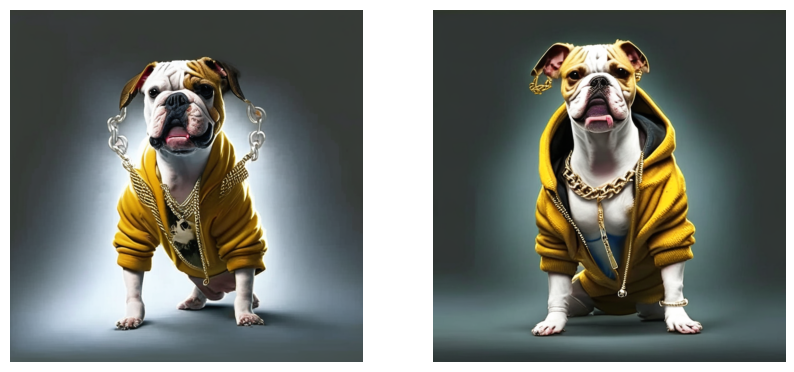

In [ ]:
# 이미지 생성 : 힙합 불독
g_image(db_index, 0.5, 5) # 0.5 : 텍스트 반영 비율 / 5 : 중요도에 비례하게 5배의 사진 검색

query :I want to create an ad for a hoodie worn by puppies. I want to show a pack of puppies in hoodies running through a park. There should be about 4 puppies and different breeds, and the hoodies should be different colors.


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
add top k image
42
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

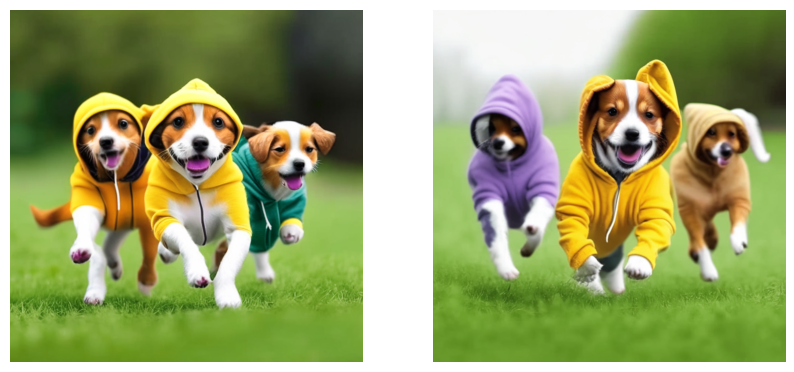

In [ ]:
# 이미지 생성 : 강아지 후드티 광고
g_image(db_index, 0.5, 5)

query :I want to create an ad for a hoodie worn by puppies. I want to show a pack of puppies in hoodies running through a park. There should be about 4 puppies and different breeds, and the hoodies should be different colors. 100%


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
add top k image
7
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

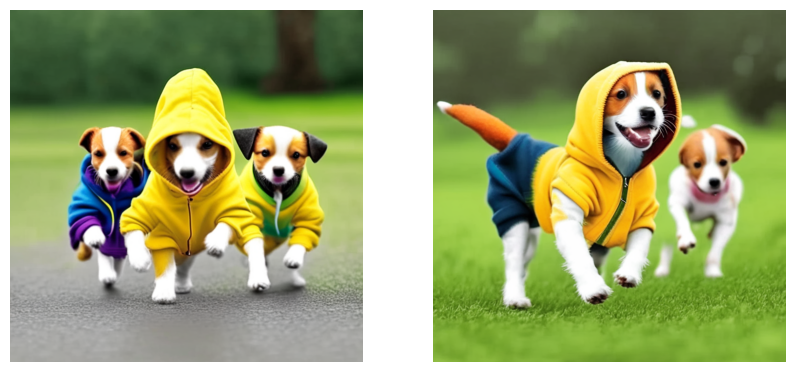

In [ ]:
# 검색 사진 수량 감소
g_image(db_index, 0.5, 1)

query :I want to create an ad for a hoodie worn by puppies. I want to show a pack of puppies in hoodies running through a park. There should be about 4 puppies and different breeds, and the hoodies should be different colors.


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
add top k image
7
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

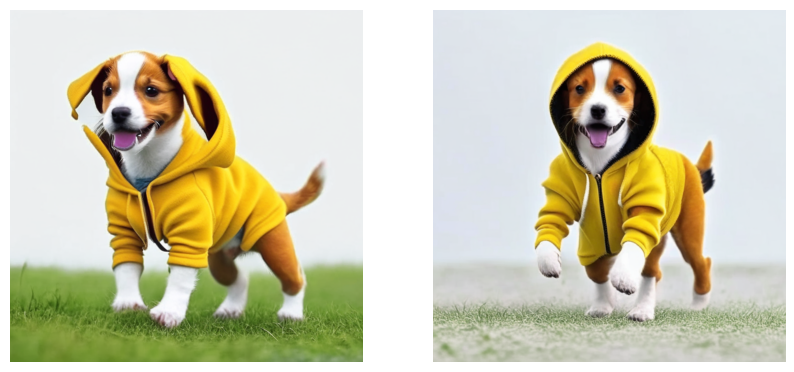

In [ ]:
# 입력 이미지의 가중치 비율 상승
g_image(db_index, 0.3, 1)

query :I want to create an ad for a hoodie worn by puppies. I want to show a pack of puppies in hoodies running through a park. There should be about 4 puppies and different breeds, and the hoodies should be different colors.


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
add top k image
7
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

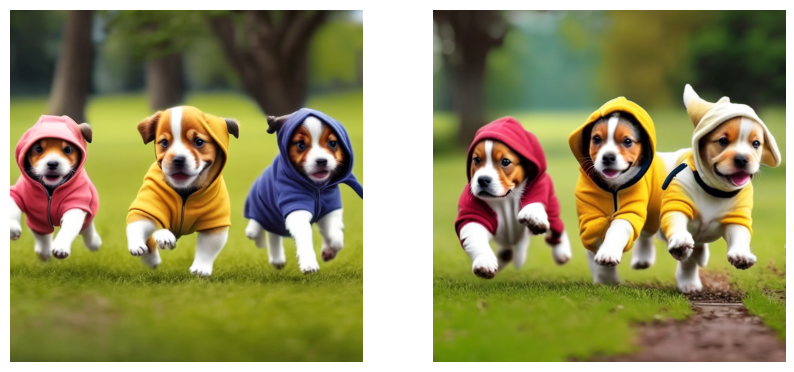

In [ ]:
# 텍스트 입력의 비율 상승
g_image(db_index, 0.7, 1)

query :I want to create an ad for a hoodie worn by puppies. I want to show a pack of puppies in hoodies running through a park. There should be about 4 puppies and different breeds, and the hoodies should be different colors.


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
add top k image
52
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

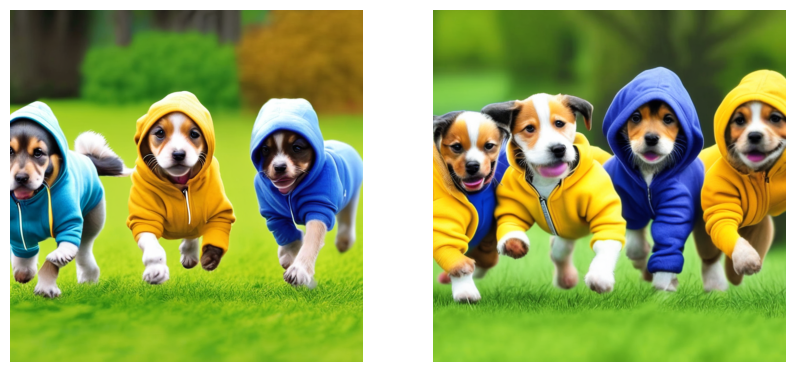

In [ ]:
# 텍스트 입력 비율 상승 + 검색 사진 증가
g_image(db_index, 0.7, 5)

query :I want to create an ad for a hoodie worn by puppies. I want to show a pack of puppies in hoodies running through a park. There should be about 4 puppies and different breeds, and the hoodies should be different colors.


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
add top k image
17
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

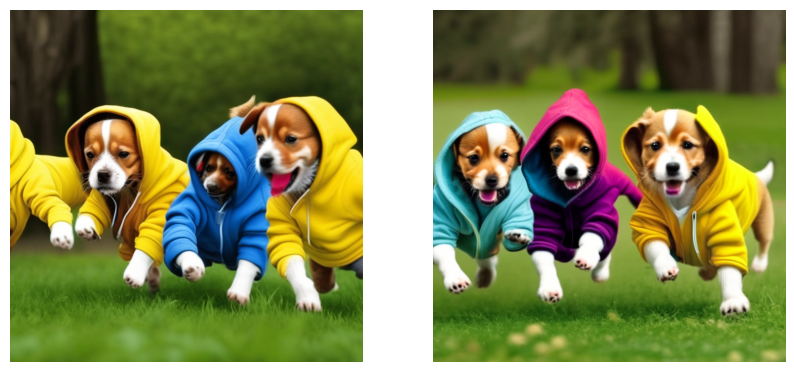

In [ ]:
g_image(db_index, 0.7, 3)

query :I want to create an ad for a hoodie worn by puppies. I want to show a pack of puppies in hoodies running through a park. There should be about 4 puppies and different breeds, and the hoodies should be different colors.


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
add top k image
26
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

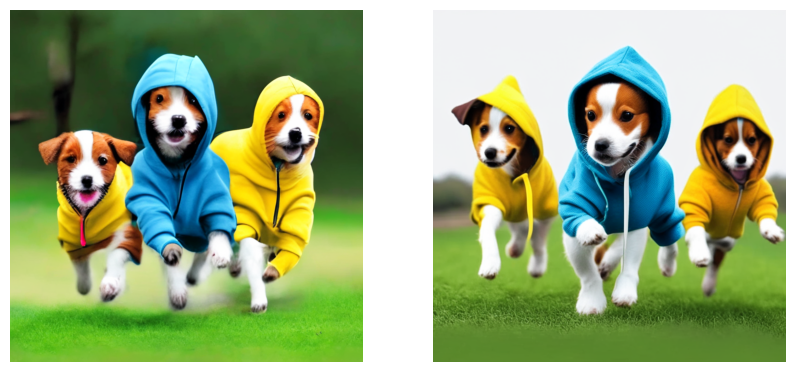

In [ ]:
g_image(db_index, 0.5, 3)

query :I want to create an ad for a hoodie worn by puppies. I want to show a pack of puppies in hoodies running through a park. There should be about 4 puppies and different breeds, and the hoodies should be different colors.


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
add top k image
82
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

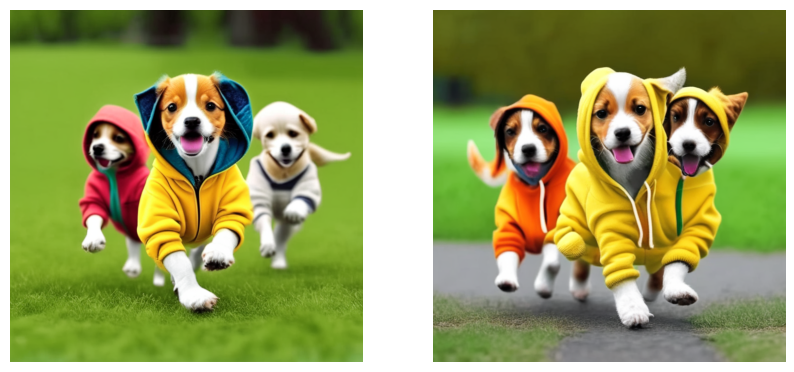

In [ ]:
g_image(db_index, 0.5, 10)

query :This stylish dog collar combines navy fabric with beige leather details. Featuring a gold-tone buckle and a matching tag. The dog wearing the collar, sits on a cushion, gazing at its owner with loving eyes.


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
torch.Size([1, 768])
add top k image
27
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

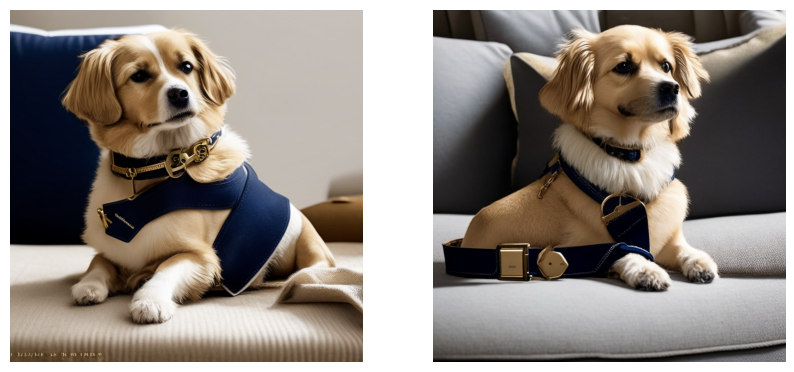

In [ ]:
# 강아지의 목줄 광고
g_image(db_index, 0.5, 3)

query :This stylish dog collar combines navy fabric with beige leather details. Featuring a gold-tone buckle and a matching tag. The dog wearing the collar, sits on a cushion, gazing at its owner with loving eyes.


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
torch.Size([1, 768])
add top k image
73
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

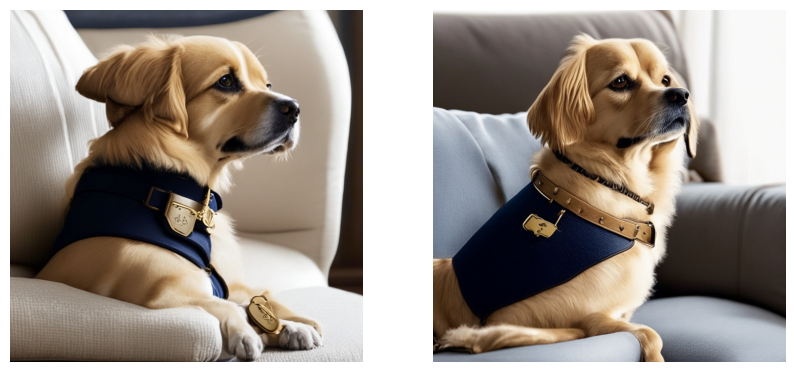

In [ ]:
g_image(db_index, 0.5, 10)

query :This stylish dog collar combines navy fabric with beige leather details. Featuring a gold-tone buckle and a matching tag. The dog wearing the collar, sits on a cushion, gazing at its owner with loving eyes.


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
torch.Size([1, 768])
add top k image
24
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

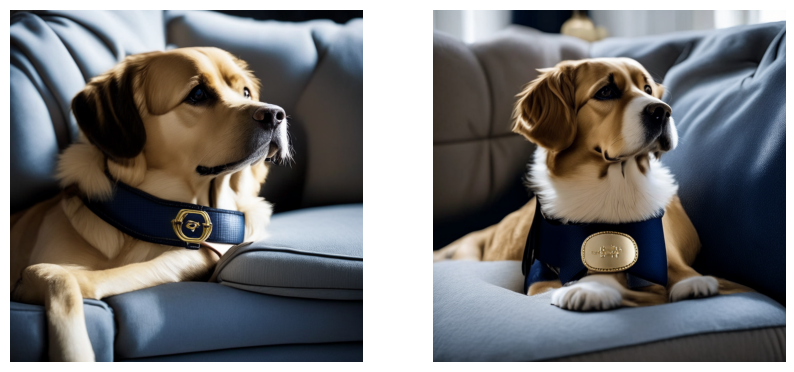

In [ ]:
g_image(db_index, 0.6, 3)

## **KEYBERT 활용하여 입력 쿼리 재구성**
- 최종 쿼리에 KETBERT로 추출한 쿼리의 키워드를 입력

In [ ]:
!pip install keybert
!pip install --upgrade sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
from keybert import KeyBERT

query_text = 'I want to create an ad for a hoodie worn by puppies. I want to show a pack of puppies in hoodies running through a park. There should be about 4 puppies and different breeds, and the hoodies should be different colors.'

# 모델 로드
kw_model = KeyBERT()


# 키워드 추출 (top_n: 추출할 개수)
keywords = kw_model.extract_keywords(query_text,
                                     keyphrase_ngram_range=(2, 4),
                                     stop_words='english',
                                     use_mmr=True,
                                     top_n=3)

print("추출된 키워드:", keywords)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

추출된 키워드: [('ad hoodie worn puppies', 0.72), ('want create ad', 0.4438), ('different colors', 0.3199)]


In [ ]:
keywords_list = [keyword for keyword, _ in keywords]
weights_list = [weight for _, weight in keywords]
weights_list

[0.72, 0.4438, 0.3199]

In [ ]:
def g_image_keyword(db_index, input_ratio, k) :

    # 쿼리문
    query_text = input('query :')

    # LLM 템플릿 구성
    template = """
    You are an expert in visual content decomposition and summarization for image generation. Your task is to analyze the given query text, extract key visual elements, and generate a concise yet comprehensive summary that preserves the essence of the original input while making it more efficient for image generation.

    ### **Instructions:**
    1. Carefully read the **query text** and extract the key visual elements that must appear in the generated image.
    2. Ensure that each extracted visual element is **specific and descriptive**. Use details from the query text where possible.
    3. Assign an **importance weight** (a value between 0 and 1) to each visual element, ensuring that the sum of all weights equals exactly **1**.
      - More crucial elements should have higher weights.
      - Less significant elements should have lower weights.
    4. Generate a **single-sentence summary (`query_text_sum`)** that captures all essential elements of the original query text while improving clarity and efficiency for image generation.
      - Keep all elements **connected in a single continuous sentence** to emphasize that they coexist in the same image.
      - Remove unnecessary words, redundancies, or overly complex structures.
      - Preserve the intent and artistic vision of the original query text.
    5. **Your response must be in strict JSON format**, containing both:
      - `visual_elements`: The extracted visual elements with their importance scores.
      - `query_text_sum`: The optimized summary text for final image generation.

    ### **Example Format:**
    ```json
    {{
      "visual_elements": {{
        "children playing in a park": 0.3,
        "sunset in the background": 0.2,
        "bench with an elderly couple": 0.25,
        "a dog running in the grass": 0.25
      }},
      "query_text_sum": "In a beautiful park at sunset, children are playing joyfully while an elderly couple sits on a bench watching, as a dog runs through the grass."
    }}


    Query Text:
    "{query_text}"
    """
    chat_prompt = ChatPromptTemplate.from_template(template)
    llm = ChatOpenAI(model_name="gpt-4o", temperature=0.2)
    chain = chat_prompt | llm | StrOutputParser()
    result = chain.invoke({"query_text": query_text})

    cleaned_content = result.strip("```json").strip("```").strip()
    cleaned_content = cleaned_content.replace("\n", "").replace("\\", "")
    result_json = json.loads(cleaned_content)

    # 추출된 시각 요소(visual elements)와 가중치
    visual_elements = result_json["visual_elements"]

    # 최종 이미지 생성에 사용될 요약된 query_text
    query_text_sum = result_json["query_text_sum"]

    # 모델 로드
    kw_model = KeyBERT()

    # 키워드 추출 (top_n: 추출할 개수)
    keywords = kw_model.extract_keywords(query_text_sum,
                                        keyphrase_ngram_range=(2, 4),
                                        stop_words='english',
                                        use_mmr=True,
                                        top_n=len(visual_elements))

    keywords_list = [keyword for keyword, _ in keywords]
    weights_list = [weight for _, weight in keywords]

    # 이미지 요소 및 중요도 리스트 생성
    image_elements = list(visual_elements.keys())  # 이미지 요소 리스트
    importance_weights = np.array(list(visual_elements.values()))  # 중요도 리스트

    min_importance = min(importance_weights)  # 최소 중요도 찾기
    image_counts = np.ceil(1 + (importance_weights / min_importance - 1)).astype(int) * k

    retrieved_images = []  # FAISS에서 검색된 이미지 벡터 저장
    retrieved_weights = []  # 해당 이미지들의 가중치 저장

    for elem, count, weight in zip(image_elements, image_counts, importance_weights):
        # 검색 시 distances도 함께 반환받음.
        similar_images_emb, distances = search_similar_images(elem, db_index, top_k=int(count))
        # similar_images_emb: torch tensor of shape (count, d)
        # distances: numpy array of shape (1, count)

        sim_np = similar_images_emb.cpu().numpy()
        dist_np = distances[0]  # shape: (count,)

        for i in range(sim_np.shape[0]):
            # 각 검색된 이미지에 대해 유사도 계산 (유사도가 높을수록 weight 반영이 커짐)
            similarity = 1 / (1 + dist_np[i])

            # 기존 weight 분배에 유사도를 곱함
            final_weight = (weight / count) * similarity

            retrieved_images.append(sim_np[i])
            retrieved_weights.append(final_weight)

    keyword = " ".join(keywords_list)
    images_texts = [keyword] + input_images

    # 주 입력에 대한 가중치: 텍스트 프롬프트와 입력 이미지에 대한 가중치를 개별적으로 결정합니다.
    text_prompt_weight = input_ratio
    input_total_weight = 1 - text_prompt_weight
    input_weights = [input_total_weight / len(input_images)] * len(input_images)
    main_weights = [text_prompt_weight] + input_weights

    # 보충 이미지(검색 결과) 및 보충 가중치는 별도의 인자로 전달 --
    top_k_image = torch.tensor(np.array(retrieved_images), dtype=torch.float32).to("cuda", dtype=torch.float16)
    top_k_w = retrieved_weights

    # Kandinsky Prior Pipeline 실행
    prior_out = pipe_prior.interpolate(
        images_texts,
        main_weights,
        search_k=True,
        top_k_image=top_k_image,
        top_k_w=top_k_w
    )

    new_image_add = pipe(
        keyword,  # 최종 프롬프트 (원본 쿼리문 또는 combined_query_text)
        **prior_out,
        height=768,
        width=768,
        num_images_per_prompt=2
    ).images

    import matplotlib.pyplot as plt
    if len(new_image_add) > 1:
        plt.figure(figsize=(10, 5))
        for i in range(len(new_image_add)):
            plt.subplot(1, len(new_image_add), i + 1)
            plt.imshow(new_image_add[i])
            plt.axis('off')
        plt.show()
    else:
        new_image_add[0].show()

query :This stylish dog collar combines navy fabric with beige leather details. Featuring a gold-tone buckle and a matching tag. The dog wearing the collar, sits on a cushion, gazing at its owner with loving eyes.


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
torch.Size([1, 768])
add top k image
43
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

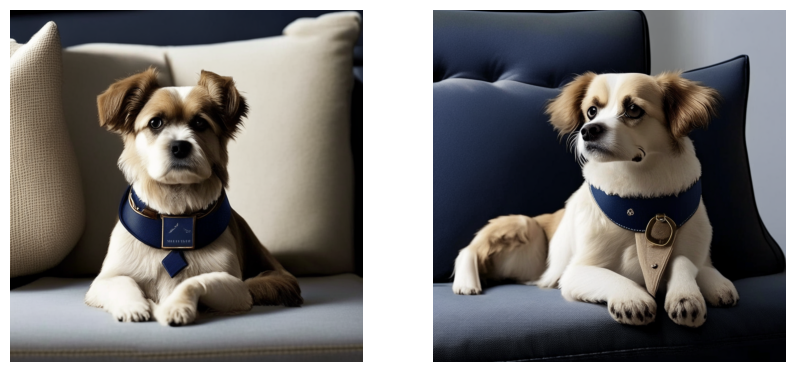

In [ ]:
g_image_keyword(db_index, 0.5, 5)

## **키워드 가중지 반영**

In [ ]:
def g_image_keyword(db_index, input_ratio, k):
    # 쿼리문 입력
    query_text = input('query :')

    # LLM 템플릿 구성
    template = """
    You are an expert in visual content decomposition and summarization for image generation. Your task is to analyze the given query text, extract key visual elements, and generate a concise yet comprehensive summary that preserves the essence of the original input while making it more efficient for image generation.

    ### **Instructions:**
    1. Carefully read the **query text** and extract the key visual elements that must appear in the generated image.
    2. Ensure that each extracted visual element is **specific and descriptive**. Use details from the query text where possible.
    3. Assign an **importance weight** (a value between 0 and 1) to each visual element, ensuring that the sum of all weights equals exactly **1**.
       - More crucial elements should have higher weights.
       - Less significant elements should have lower weights.
    4. Generate a **single-sentence summary (`query_text_sum`)** that captures all essential elements of the original query text while improving clarity and efficiency for image generation.
       - Keep all elements **connected in a single continuous sentence** to emphasize that they coexist in the same image.
       - Remove unnecessary words, redundancies, or overly complex structures.
       - Preserve the intent and artistic vision of the original query text.
    5. **Your response must be in strict JSON format**, containing both:
       - `visual_elements`: The extracted visual elements with their importance scores.
       - `query_text_sum`: The optimized summary text for final image generation.

    ### **Example Format:**
    ```json
    {{
      "visual_elements": {{
        "children playing in a park": 0.3,
        "sunset in the background": 0.2,
        "bench with an elderly couple": 0.25,
        "a dog running in the grass": 0.25
      }},
      "query_text_sum": "In a beautiful park at sunset, children are playing joyfully while an elderly couple sits on a bench watching, as a dog runs through the grass."
    }}


    Query Text:
    "{query_text}"
    """
    chat_prompt = ChatPromptTemplate.from_template(template)
    llm = ChatOpenAI(model_name="gpt-4o", temperature=0.2)
    chain = chat_prompt | llm | StrOutputParser()
    result = chain.invoke({"query_text": query_text})

    cleaned_content = result.strip("```json").strip("```").strip()
    cleaned_content = cleaned_content.replace("\n", "").replace("\\", "")
    result_json = json.loads(cleaned_content)

    # 추출된 시각 요소(visual elements)와 가중치
    visual_elements = result_json["visual_elements"]

    # 최종 이미지 생성에 사용될 요약된 query_text
    query_text_sum = result_json["query_text_sum"]

    # 모델 로드 및 키워드 추출
    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(query_text_sum,
                                         keyphrase_ngram_range=(2, 4),
                                         stop_words='english',
                                         use_mmr=True,
                                         top_n=len(visual_elements))
    # keywords_list와 weights_list 추출
    keywords_list = [keyword for keyword, _ in keywords]
    weights_list = [weight for _, weight in keywords]

    # 이미지 요소 및 중요도 리스트 생성
    image_elements = list(visual_elements.keys())
    importance_weights = np.array(list(visual_elements.values()))
    min_importance = min(importance_weights)
    image_counts = np.ceil(1 + (importance_weights / min_importance - 1)).astype(int) * k

    retrieved_images = []  # FAISS에서 검색된 이미지 벡터 저장
    retrieved_weights = []  # 해당 이미지들의 가중치 저장

    for elem, count, weight in zip(image_elements, image_counts, importance_weights):
        similar_images_emb, distances = search_similar_images(elem, db_index, top_k=int(count))
        sim_np = similar_images_emb.cpu().numpy()
        dist_np = distances[0]  # shape: (count,)

        for i in range(sim_np.shape[0]):
            similarity = 1 / (1 + dist_np[i])
            final_weight = (weight / count) * similarity
            retrieved_images.append(sim_np[i])
            retrieved_weights.append(final_weight)

    images_texts = keywords_list + input_images

    # 키워드별 weights_list를 input_ratio에 맞춰 정규화합니다.
    total_keyword_weight = sum(weights_list)
    normalized_keyword_weights = [(w / total_keyword_weight) * input_ratio for w in weights_list]

    # 이미지 입력에 대한 가중치 설정 (나머지 전체를 균등 분배)
    input_total_weight = 1 - input_ratio
    input_weights = [input_total_weight / len(input_images) for _ in input_images]

    # 최종적으로 text_input(키워드)와 input_image의 가중치를 결합합니다.
    main_weights = normalized_keyword_weights + input_weights

    # FAISS 검색 결과를 텐서로 변환
    top_k_image = torch.tensor(np.array(retrieved_images), dtype=torch.float32).to("cuda", dtype=torch.float16)
    top_k_w = retrieved_weights

    # Kandinsky Prior Pipeline 실행
    prior_out = pipe_prior.interpolate(
        images_texts,
        main_weights,
        search_k=True,
        top_k_image=top_k_image,
        top_k_w=top_k_w
    )

    # 최종 텍스트 프롬프트는 키워드들을 공백으로 연결한 문자열을 사용합니다.
    combined_keyword = ", ".join(keywords_list)
    new_image_add = pipe(
        query_text_sum,
        **prior_out,
        height=768,
        width=768,
        num_images_per_prompt=2
    ).images

    import matplotlib.pyplot as plt
    if len(new_image_add) > 1:
        plt.figure(figsize=(10, 5))
        for i in range(len(new_image_add)):
            plt.subplot(1, len(new_image_add), i + 1)
            plt.imshow(new_image_add[i])
            plt.axis('off')
        plt.show()
    else:
        new_image_add[0].show()


query :This stylish dog collar combines navy fabric with beige leather details. Featuring a gold-tone buckle and a matching tag. The dog wearing the collar, sits on a cushion, gazing at its owner with loving eyes.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
torch.Size([1, 768])
add top k image
23
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

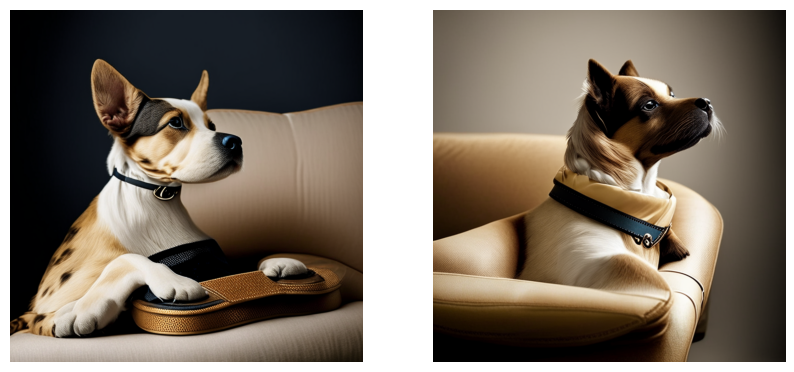

In [ ]:
g_image_keyword(db_index, 0.7, 2)